In [6]:
!pip install xgboost
!pip install pickle5
!pip install umap-learn
!pip install umap-learn[plot]

     |████████████████████████████████| 132 kB 850 kB/s eta 0:00:01
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=245873 sha256=84085b42d83b288575bf140013ecbf1b8cff6ba9a58b8734cf967aeee8ae2646
  Stored in directory: /home/ubuntu/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


In [1]:
from multiscorer.multiscorer import MultiScorer
#Scikit's libraries for demonstration
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, roc_auc_score
from numpy import average
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection  import GridSearchCV
from sklearn.svm import SVC 

import pickle5 as pickle

# GradientBoosting
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [ ]:
#AMPs_df = pd.read_pickle('../../datasets/AMPsNonAMPs_df.239.plk')
AMPs_df = pd.read_pickle('/mnt/vdb/thesis/jax/AMPNonAMP.final.reps')
AMPs_df.drop_duplicates(subset=['Sequence'],inplace=True)
AMPs_df


In [2]:
with open( "/mnt/vdb/thesis/jax/AMPNonAMP.final.reps", 'rb') as file:
    AMPs_df = pickle.load(file)
AMPs_df

,ID,length,class,reps
1272,0_antitbpred|antitbpred,33,0,"[0.020596178248524666, 0.05145363137125969, 0...."
1463,0_peptideDB.anti|peptideDB.anti,148,0,"[0.006680205464363098, -0.09558606147766113, 0..."
712,1000_pos_train_ds3|pos_train_ds3,86,0,"[0.010705528780817986, 0.005044564604759216, 0..."
1111,"10015_dbaasp,10016_dbaasp|dbaasp_peptides",11,0,"[0.20464208722114563, -0.055944692343473434, 0..."
618,10023_dbaasp|dbaasp_peptides,36,0,"[0.0020729468669742346, -0.07690200209617615, ..."
...,...,...,...,...
341,jgi|Zymar1|771619|Za111_scaffold_384_0026,92,0,"[0.006163035519421101, -0.1501017063856125, 0...."
342,jgi|Zymbr1|3072|TI39_contig368g00016T0,769,0,"[0.004322961904108524, -0.039575327187776566, ..."
345,jgi|Zymps1|796288|Zp221_scaffold_1306_00022,790,0,"[0.0037672598846256733, -0.036420367658138275,..."
344,jgi|Zymps1|799992|Zp221_scaffold_243_00026,155,0,"[0.0039311423897743225, -0.01658601127564907, ..."


In [3]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
def confusion_Matrix(classifier, X_test, y_test):
    class_names = ['AMPs', 'NonAMPs']

    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                display_labels = class_names,
                                cmap=plt.cm.Blues, xticks_rotation='vertical')

    disp.ax_.set_title(" Confusion Matrix")

    print(disp.confusion_matrix)
    plt.grid(False)
    plt.show()

# RF

In [12]:
from sklearn.ensemble import RandomForestClassifier 
RFclassifier = RandomForestClassifier ( random_state=42)
RFclassifier.fit(X_train, y_train)
y_pred = RFclassifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      8873
           1       0.90      0.92      0.91      8866

    accuracy                           0.91     17739
   macro avg       0.91      0.91      0.91     17739
weighted avg       0.91      0.91      0.91     17739

0.9093522746490783
[[7963  910]
 [ 698 8168]]


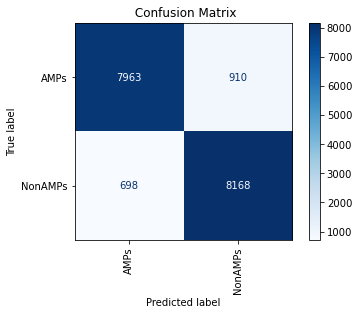

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
confusion_Matrix(RFclassifier, X_test, y_test)

In [ ]:
score = cross_val_score(RFclassifier, X_testX, y_test, scoring='accuracy', cv=10,n_jobs=20,).mean()#
print('Cross-Validation Accuracy:', score, '\n', '\n')

In [ ]:

scorer = MultiScorer({
  'accuracy': (accuracy_score, {}),
  'precision': (precision_score, {}),
  'recall': (recall_score, {}),
  'f1': (f1_score, {}), 
  'roc_auc': (roc_auc_score, {}),
  'neg_log_loss': (log_loss, {}), 
})
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cross_val_score(RFclassifier, X, y, cv=kfold, scoring=scorer )

In [ ]:
# new
results = scorer.get_results()
for metric in results.keys():
  print("%s: %.3f" % (metric, average(results[metric])))

In [14]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall', 'precision','neg_log_loss']
scores = cross_validate(
    RFclassifier,  X_test, y_test, scoring=scoring, cv=kfold, return_train_score=True)
print("Accuracy TEST: %0.2f (+/- %0.2f) Accuracy TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print("F1 TEST: %0.2f (+/- %0.2f) F1 TRAIN : %0.2f (+/- %0.2f) " %
      (scores['test_f1'].mean(), scores['test_f1'].std() * 2, scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print("AUROC TEST: %0.2f (+/- %0.2f) AUROC TRAIN : %0.2f (+/- %0.2f)" %
      (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2, scores['train_roc_auc'].mean(), scores['train_roc_auc'].std() * 2))
print("recall TEST: %0.2f (+/- %0.2f) recall TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_recall'].mean(), scores['test_recall'].std() * 2, scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("Precision TEST: %0.2f (+/- %0.2f) Precision TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_precision'].mean(), scores['test_precision'].std() * 2, scores['train_precision'].mean(), scores['train_precision'].std() * 2))

NameError: name 'X_testX' is not defined

In [ ]:
rint("Log loss TEST: %0.2f (+/- %0.2f) Log loss TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std() * 2, scores['train_neg_log_loss'].mean(), scores['train_neg_log_loss'].std() * 2))

In [ ]:
# old
results = scorer.get_results()
for metric in results.keys():
  print("%s: %.3f" % (metric, average(results[metric])))

# SVM

In [6]:
# linear model 
svm_model =SVC()
svm_model.fit(X_train, y_train) 

SVC()

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      8873
           1       0.90      0.93      0.92      8866

    accuracy                           0.91     17739
   macro avg       0.92      0.91      0.91     17739
weighted avg       0.92      0.91      0.91     17739

[[7986  887]
 [ 622 8244]]


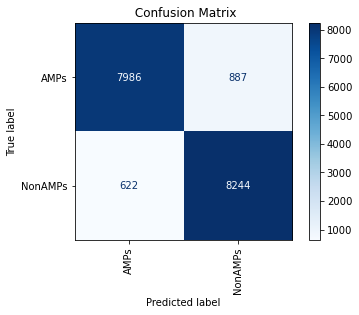

In [7]:
grid_predictions = svm_model.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
confusion_Matrix(svm_model, X_test, y_test)

In [8]:
with open('/mnt/vdb/thesis/best_SVM.linear.model', 'wb') as f:
    pickle.dump(svm_model, f)

In [ ]:
svm_model =SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)
svm_model.fit(X_train, y_train) 

[LibSVM]

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      8873
           1       0.93      0.94      0.94      8866

    accuracy                           0.94     17739
   macro avg       0.94      0.94      0.94     17739
weighted avg       0.94      0.94      0.94     17739

[[8278  595]
 [ 488 8378]]


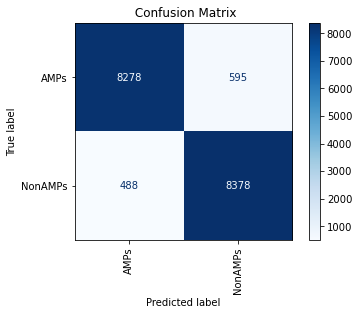

In [20]:
grid_predictions = svm_model.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, grid_predictions)) 
confusion_Matrix(svm_model, X_test, y_test)

In [19]:
import pickle
# now you can save it to a file
with open('best_SVM.model', 'wb') as f:
    pickle.dump(svm_model, f)
    #with open('svm_model.pkl', 'rb') as f:
    #svm_model = pickle.load(f)

In [8]:
svm_model =SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=True)
score = cross_val_score(svm_model, X, y, cv=10, n_jobs=20, scoring='accuracy').mean()
print('Cross-Validation Accuracy:', score, '\n', '\n')

Cross-Validation Accuracy: 0.8625358221860651 
 



In [6]:
svm_model =SVC()
score = cross_val_score(svm_model, X, y, cv=10, n_jobs=2, scoring='accuracy').mean()
print('Cross-Validation Accuracy:', score, '\n', '\n')

Cross-Validation Accuracy: 0.857029261081841 
 



In [7]:
## use the package from gituhb
scorer = MultiScorer({
  'accuracy': (accuracy_score, {}),
  'precision': (precision_score, {}),
  'recall': (recall_score, {}),
  'f1': (f1_score, {}), 
  'roc_auc': (roc_auc_score, {}),
  'neg_log_loss': (log_loss, {}), 
    
})


In [ ]:
svm_model =SVC()
cross_val_score(svm_model, X, y, cv=10, scoring=scorer )
#print('Cross-Validation Accuracy:', score, '\n', '\n')

In [18]:
results = scorer.get_results()
for metric in results.keys():
  print("%s: %.3f" % (metric, average(results[metric])))

accuracy: 0.857
precision: 0.829
recall: 0.922
f1: 0.869
roc_auc: 0.858
neg_log_loss: 4.938


In [ ]:
svm_model =SVC(probability=True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall', 'precision','neg_log_loss']
scores = cross_validate(
    svm_model, X, y, scoring=scoring, cv=kfold, return_train_score=True)
print("Accuracy TEST: %0.2f (+/- %0.2f) Accuracy TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print("F1 TEST: %0.2f (+/- %0.2f) F1 TRAIN : %0.2f (+/- %0.2f) " %
      (scores['test_f1'].mean(), scores['test_f1'].std() * 2, scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print("AUROC TEST: %0.2f (+/- %0.2f) AUROC TRAIN : %0.2f (+/- %0.2f)" %
      (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2, scores['train_roc_auc'].mean(), scores['train_roc_auc'].std() * 2))
print("recall TEST: %0.2f (+/- %0.2f) recall TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_recall'].mean(), scores['test_recall'].std() * 2, scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("Precision TEST: %0.2f (+/- %0.2f) Precision TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_precision'].mean(), scores['test_precision'].std() * 2, scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Log loss TEST: %0.2f (+/- %0.2f) Log loss TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std() * 2, scores['train_neg_log_loss'].mean(), scores['train_neg_

## XGBmodel (Gradient Boosting)

## Hyperparameter Tuning
hyperparameters to tune, perhaps the most important are as follows:

* The number of trees or estimators in the model.
* The learning rate of the model.
* The row and column sampling rate for stochastic models.
* The maximum tree depth.
* The minimum tree weight.
* The regularization terms alpha and lambda.

How to configure or tune the configuration of gradient boosting algorithm?

In [6]:
X_train.shape

(33560, 1900)

In [9]:
param_grid =  {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
               "n_estimators": [100,200,500,1000],
                 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                 "min_child_weight" : [ 1, 3, 5, 7 ],
                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [ ]:
#param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],'n_estimators': [100,200,500,1000],
#              'max_depth': [4, 6], 'min_samples_leaf': [3, 5, 9, 17], 'max_features': [1.0, 0.3, 0.1]}
#est = GradientBoostingClassifier() 
param_grid =  {     'learning_rate': [0.01, 0.1],
                    'max_depth': [3, 5, 7, 10],
                    'min_child_weight': [1, 3, 5],
                    'subsample': [0.5, 0.7],
                    'colsample_bytree': [0.5, 0.7],
                    'n_estimators' : [100,300]
              }
param_grid =  {     'learning_rate': [0.1],
                    'max_depth': [10,12,15],
                    'min_child_weight': [ 3],
                    'gamma': [0.3, 0.4],
                    'n_estimators' : [500,1000]
              }
XGBmodel = XGBClassifier( n_jobs=10, random_state=42, verbosity=1)
gs_XGBmodel_cv = GridSearchCV(XGBmodel, param_grid, cv=5, verbose=2).fit(X_train,y_train) 

In [8]:
gs_XGBmodel_cv.best_params_

{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500}

In [8]:
# old one
gs_XGBmodel_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 300,
 'subsample': 0.7}

In [9]:
score = cross_val_score(gs_XGBmodel_cv.best_estimator_, X, y, scoring='accuracy', cv=5).mean()#
print('Cross-Validation Accuracy:', score, '\n', '\n')

Cross-Validation Accuracy: 0.7274722406051436 
 



In [ ]:
# Use this one 
XGBmodel = XGBClassifier( n_jobs=20, random_state=42, verbosity=1)
XGBmodel.fit(X_train,y_train) 

In [ ]:
pred = XGBmodel.predict(X_test)
print(classification_report(y_test,pred))
print("Accuracy:"+str(accuracy_score(y_test, pred)))
confusion_Matrix(XGBmodel, X_test, y_test)

In [ ]:
# use from fitted
score = cross_val_score(XGBmodel, X, y, scoring='accuracy', cv=10).mean()#
print('Cross-Validation Accuracy:', score, '\n', '\n')

In [ ]:
GBmodel = XGBClassifier( n_jobs=24, random_state=42, verbosity=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall', 'precision','neg_log_loss']
scores = cross_validate(
    XGBmodel, X, y, scoring=scoring, cv=kfold, return_train_score=True)
print("Accuracy TEST: %0.2f (+/- %0.2f) Accuracy TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print("F1 TEST: %0.2f (+/- %0.2f) F1 TRAIN : %0.2f (+/- %0.2f) " %
      (scores['test_f1'].mean(), scores['test_f1'].std() * 2, scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print("AUROC TEST: %0.2f (+/- %0.2f) AUROC TRAIN : %0.2f (+/- %0.2f)" %
      (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2, scores['train_roc_auc'].mean(), scores['train_roc_auc'].std() * 2))
print("recall TEST: %0.2f (+/- %0.2f) recall TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_recall'].mean(), scores['test_recall'].std() * 2, scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("Precision TEST: %0.2f (+/- %0.2f) Precision TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_precision'].mean(), scores['test_precision'].std() * 2, scores['train_precision'].mean(), scores['train_precision'].std() * 2))

In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc', 'recall', 'precision','neg_log_loss']
scores = cross_validate(
    XGBmodel, X, y, scoring=scoring, cv=kfold, return_train_score=True)
print("Accuracy TEST: %0.2f (+/- %0.2f) Accuracy TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2, scores['train_accuracy'].mean(), scores['train_accuracy'].std() * 2))
print("F1 TEST: %0.2f (+/- %0.2f) F1 TRAIN : %0.2f (+/- %0.2f) " %
      (scores['test_f1'].mean(), scores['test_f1'].std() * 2, scores['train_f1'].mean(), scores['train_f1'].std() * 2))
print("AUROC TEST: %0.2f (+/- %0.2f) AUROC TRAIN : %0.2f (+/- %0.2f)" %
      (scores['test_roc_auc'].mean(), scores['test_roc_auc'].std() * 2, scores['train_roc_auc'].mean(), scores['train_roc_auc'].std() * 2))
print("recall TEST: %0.2f (+/- %0.2f) recall TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_recall'].mean(), scores['test_recall'].std() * 2, scores['train_recall'].mean(), scores['train_recall'].std() * 2))
print("Precision TEST: %0.2f (+/- %0.2f) Precision TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_precision'].mean(), scores['test_precision'].std() * 2, scores['train_precision'].mean(), scores['train_precision'].std() * 2))
print("Log loss TEST: %0.2f (+/- %0.2f) Log loss TRAIN: %0.2f (+/- %0.2f)" %
      (scores['test_neg_log_loss'].mean(), scores['test_neg_log_loss'].std() * 2, scores['train_neg_log_loss'].mean(), scores['train_neg_log_loss'].std() * 2))

## Evaluate the model